# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Obtain Data

Read csv with election results into pandas, scrub county names to match formatting of census data, filter for 2020 Biden vote proportion and drop unneeded columns

In [ ]:
biden_csv_df = pd.read_csv('../Data/election_results.csv')
biden_csv_df = biden_csv_df[(biden_csv_df['year']==2020) & (biden_csv_df['candidate']=='JOSEPH R BIDEN JR')]
biden_csv_df['County'] = biden_csv_df.apply(lambda x: x['county_name'].title() + ' County, ' + x['state'].title(),
                                            axis=1)

trump_csv_df = pd.read_csv('../Data/election_results.csv')
trump_csv_df = trump_csv_df[(trump_csv_df['year']==2020) & (trump_csv_df['candidate']=='DONALD J TRUMP')]
trump_csv_df['County'] = trump_csv_df.apply(lambda x: x['county_name'].title() + ' County, ' + x['state'].title(),
                                            axis=1)

def filter_election_csv(election_csv_df):
    candidate = election_csv_df['candidate'].values[0].title()
    election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('City County', 'City'))
    election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('County County', 'County'))
    election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('Saint', 'St.'))
    election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('St ', 'St. '))
    election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('District Of Columbia County', 'District Of Columbia'))
    election_csv_df = election_csv_df[['County', 'candidatevotes', 'totalvotes', 'mode']]
    election_df = pd.DataFrame(election_csv_df.groupby(by='County', axis=0).sum()['candidatevotes'])
    election_df.reset_index(inplace=True)
    election_df.columns=['County', f'{candidate} Votes']
    election_df['Total Votes'] = election_csv_df.groupby(by='County', axis=0).max()['totalvotes'].values
    return election_df

biden_csv_df = filter_election_csv(biden_csv_df)
trump_csv_df = filter_election_csv(trump_csv_df)
election_df = pd.merge(biden_csv_df, trump_csv_df, on=['County', 'Total Votes'])
    
print('election_df shape:', election_df.shape)
election_df.head()

election_df shape: (3155, 4)


,County,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes
0,"Abbeville County, South Carolina",4101.0,12433.0,8215.0
1,"Acadia County, Louisiana",5443.0,28425.0,22596.0
2,"Accomack County, Virginia",7578.0,16962.0,9172.0
3,"Ada County, Idaho",120539.0,259389.0,130699.0
4,"Adair County, Iowa",1198.0,4177.0,2922.0


Read csv with county areas into pandas, scrub county names to match formatting of census data and drop unneeded columns

In [ ]:
area_df = pd.read_csv('../Data/area.csv')
area_df = area_df[['Areaname', 'LND010200D']]
area_df.columns = ['County', 'Area']
area_df['County']

state_abbrev_df = pd.read_csv('../Data/state_abbrev.csv')
def replace_abbrev(row):
    if len(row.split(',')) == 1:
        return row    
    else:
        state_abbrev = row.split(',')[1][1:]
        state = state_abbrev_df[state_abbrev_df['Code']==state_abbrev]['State'].values[0]
        return row.split(',')[0] + ' County, ' + state
area_df['County'] = area_df['County'].apply(replace_abbrev)
area_df['County'] = area_df['County'].apply(lambda x: x.title())
area_df['County'] = area_df['County'].apply(lambda x: x.replace('District Of Columbia', 'District Of Columbia, District Of Columbia'))
area_df['County'] = area_df['County'].apply(lambda x: x.replace('City County', 'City'))
print('area_df shape:', area_df.shape)
area_df.head()

area_df shape: (3198, 2)


,County,Area
0,United States,3794083.06
1,Alabama,52419.02
2,"Autauga County, Alabama",604.45
3,"Baldwin County, Alabama",2026.93
4,"Barbour County, Alabama",904.52


Update Virginia independent cities in area_df table with City instead of County to match formatting of other tables

In [ ]:
area_df['Duplicated'] = area_df['County'].duplicated()
duplicate_counties = area_df[area_df['Duplicated']==1]['County'].values

def virginia_cities(row):
    if row['County'] not in duplicate_counties:
        return row
    elif row['Area'] == max(area_df[area_df['County']==row['County']]['Area'].values):
        return row
    else:
        row['County'] = row['County'].replace('County', 'City')
        return row
area_df = area_df.apply(virginia_cities, axis=1)
area_df.drop('Duplicated', inplace=True, axis=1)
area_df.drop_duplicates(subset='County', inplace=True)
area_df.head()

,County,Area
0,United States,3794083.06
1,Alabama,52419.02
2,"Autauga County, Alabama",604.45
3,"Baldwin County, Alabama",2026.93
4,"Barbour County, Alabama",904.52


Read csv with county level education data into pandas and drop unneeded columns

In [ ]:
education_df = pd.read_csv('../Data/education.csv', header=1)
education_df = education_df[['Geographic Area Name',
                            'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over', 
                            "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"]]
education_df.columns = ['County', 'Persons 25+', 'Persons 25+ w/ Bachelors Degree']
print('education_df shape: ', education_df.shape)
education_df.head()

education_df shape:  (840, 3)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree
0,"Baldwin County, Alabama",159717,51471
1,"Calhoun County, Alabama",79084,15257
2,"Cullman County, Alabama",58795,9241
3,"DeKalb County, Alabama",47007,5999
4,"Elmore County, Alabama",57553,14310


Read csv with county level economic data into pandas and drop unneeded columns

In [ ]:
economic_df = pd.read_csv('../Data/economics.csv', header=1)
economic_df = economic_df[['Geographic Area Name',
                          'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars)',
                          'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force',
                          'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',]]
economic_df.columns = ['County', 'Per Capita Income', 'Persons 16+ in Labor Force', 'Persons 16+ Unemployed',]
print('economic_df shape: ', economic_df.shape)
economic_df.head()

economic_df shape:  (840, 4)


,County,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed
0,"Baldwin County, Alabama",32443,101561,5549
1,"Calhoun County, Alabama",24579,51001,3754
2,"Cullman County, Alabama",23968,38222,1783
3,"DeKalb County, Alabama",21939,34492,1606
4,"Elmore County, Alabama",31396,37693,1014


Read csv with county level ethnicity data into pandas and drop unneeded columns

In [ ]:
ethnicity_df = pd.read_csv('../Data/ethnicity.csv', header=1)
ethnicity_df = ethnicity_df[['Geographic Area Name',
                             'Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)',
                             'Estimate!!SEX AND AGE!!Total population',
                             'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)',
                             'Estimate!!RACE!!Total population!!One race!!White']]
ethnicity_df.columns = ['County', 'Sex Ratio (M/F)', 'Total Persons', 'Hispanic Persons', 'White Persons']
print('ethnicity_df shape: ', ethnicity_df.shape)
ethnicity_df.head()

ethnicity_df shape:  (840, 5)


,County,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons
0,"Baldwin County, Alabama",95.7,223234,10534,190912
1,"Calhoun County, Alabama",91.5,113605,4614,82323
2,"Cullman County, Alabama",94.0,83768,3752,N
3,"DeKalb County, Alabama",99.6,71513,10775,59305
4,"Elmore County, Alabama",97.4,81209,2563,61634


Read csv with county level disability data into pandas and drop unneeded columns

In [ ]:
disability_df = pd.read_csv('../Data/disability.csv', header=1)
disability_df = disability_df[['Geographic Area Name',
    'Estimate!!Percent with a disability!!Total civilian noninstitutionalized population']]
disability_df.columns = ['County', 'Disability Proportion']
print('disability_df shape: ', disability_df.shape)
disability_df.head()

disability_df shape:  (840, 2)


,County,Disability Proportion
0,"Baldwin County, Alabama",14.4
1,"Calhoun County, Alabama",20.0
2,"Cullman County, Alabama",17.5
3,"DeKalb County, Alabama",10.8
4,"Elmore County, Alabama",12.9


Read csv with county level demographic data into pandas and drop unneeded columns

In [ ]:
demographics_df = pd.read_csv('../Data/demographics.csv', header=1)
demographics_df = demographics_df[['Geographic Area Name',
                                  'Estimate!!Total!!Total population!!SUMMARY INDICATORS!!Median age (years)']]
demographics_df.columns = ['County', 'Median Age']
print('demographics_df shape: ', demographics_df.shape)
demographics_df.head()

demographics_df shape:  (840, 2)


,County,Median Age
0,"Baldwin County, Alabama",43.0
1,"Calhoun County, Alabama",39.6
2,"Cullman County, Alabama",41.9
3,"DeKalb County, Alabama",37.7
4,"Elmore County, Alabama",39.0


Read csv with county level veteran proprtion into pandas and drop unneeded columns

In [ ]:
veterans_df = pd.read_csv('../Data/veterans.csv', header=1)
veterans_df = veterans_df[['Geographic Area Name',
                           'Estimate!!Total!!Civilian population 18 years and over',
                           'Estimate!!Veterans!!Civilian population 18 years and over']]
veterans_df.columns = ['County', 'Civilians 18+', 'Veterans 18+']
print('veterans_df shape: ', veterans_df.shape)
veterans_df.head()

veterans_df shape:  (840, 3)


,County,Civilians 18+,Veterans 18+
0,"Baldwin County, Alabama",176331,19580
1,"Calhoun County, Alabama",87525,8552
2,"Cullman County, Alabama",64955,4907
3,"DeKalb County, Alabama",53737,3499
4,"Elmore County, Alabama",61837,6512


Read csv with county level employment data into pandas and drop unneeded columns

In [ ]:
occupation_df = pd.read_csv('../Data/occupation.csv', header=1)
occupation_df = occupation_df[['Geographic Area Name',
                           'Estimate!!Total!!Civilian employed population 16 years and over',
                           'Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining:!!Agriculture, forestry, fishing and hunting',
                           'Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining:!!Mining, quarrying, and oil and gas extraction',
                           'Estimate!!Total!!Civilian employed population 16 years and over!!Manufacturing']]
occupation_df.columns = ['County', 'Employees 16+', 'Agriculture Employees 16+', 'Mining Employees 16+', 
                          'Manufacturing Employees 16+']
print('occupation_df shape: ', occupation_df.shape)
occupation_df.head()

occupation_df shape:  (840, 5)


,County,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+
0,"Baldwin County, Alabama",96012,1090,205,8791
1,"Calhoun County, Alabama",45641,298,714,7044
2,"Cullman County, Alabama",36439,399,0,5282
3,"DeKalb County, Alabama",32544,845,7,9052
4,"Elmore County, Alabama",35358,101,77,4634


Merge all dfs from census sources together

In [ ]:
df = pd.merge(education_df, economic_df, on='County')
df = pd.merge(df, ethnicity_df, on='County')
df = pd.merge(df, disability_df, on='County')
df = pd.merge(df, demographics_df, on='County')
df = pd.merge(df, veterans_df, on='County')
df = pd.merge(df, occupation_df, on='County')
print('df shape:', df.shape)
df.head()

df shape: (840, 18)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912,14.4,43.0,176331,19580,96012,1090,205,8791
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323,20.0,39.6,87525,8552,45641,298,714,7044
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,N,17.5,41.9,64955,4907,36439,399,0,5282
3,"DeKalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305,10.8,37.7,53737,3499,32544,845,7,9052
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634,12.9,39.0,61837,6512,35358,101,77,4634


Scrub county names in df with census data to match county names in other dfs for subsequent merger

In [ ]:
def scrub_county(name):
    name = name.replace('Parish', 'County')
    name = name.replace('ñ', 'n')
    name = name.replace('Saint', 'St.')
    name = name.replace('City County', 'City')
    name = name.title()
    return name
df['County'] = df['County'].apply(scrub_county)

Merge df with election results df

In [ ]:
df = pd.merge(df, election_df, on='County')
print('df shape:', df.shape)
df.head()

df shape: (826, 21)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912,14.4,43.0,176331,19580,96012,1090,205,8791,24578.0,109679.0,83544.0
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323,20.0,39.6,87525,8552,45641,298,714,7044,15216.0,50983.0,35101.0
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,N,17.5,41.9,64955,4907,36439,399,0,5282,4478.0,41851.0,36880.0
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305,10.8,37.7,53737,3499,32544,845,7,9052,4281.0,29356.0,24767.0
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634,12.9,39.0,61837,6512,35358,101,77,4634,10367.0,41030.0,30164.0


Scrub area_df county names to match df county names

In [ ]:
missing_counties = pd.merge(area_df, df, on='County', how='right')[pd.merge(area_df, df, on='County', how='right').isna().max(axis=1)]['County'].values
replacement_counties = []
for county in missing_counties:
    replacement_counties.append(county.replace('City', 'County'))
for num in range(0, len(missing_counties)):
    area_df['County'] = area_df['County'].apply(lambda x: x.replace(replacement_counties[num], missing_counties[num]))

Merge df with area_df

In [ ]:
df = pd.merge(df, area_df, on='County')
print('df shape:', df.shape)
df.head()

df shape: (826, 22)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes,Area
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912,14.4,43.0,176331,19580,96012,1090,205,8791,24578.0,109679.0,83544.0,2026.93
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323,20.0,39.6,87525,8552,45641,298,714,7044,15216.0,50983.0,35101.0,612.32
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,N,17.5,41.9,64955,4907,36439,399,0,5282,4478.0,41851.0,36880.0,754.82
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305,10.8,37.7,53737,3499,32544,845,7,9052,4281.0,29356.0,24767.0,778.65
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634,12.9,39.0,61837,6512,35358,101,77,4634,10367.0,41030.0,30164.0,657.21


# Scrub Data

Use df.info() to see what data scrubbing needed

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 0 to 825
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   County                           826 non-null    object 
 1   Persons 25+                      826 non-null    int64  
 2   Persons 25+ w/ Bachelors Degree  826 non-null    int64  
 3   Per Capita Income                826 non-null    int64  
 4   Persons 16+ in Labor Force       826 non-null    int64  
 5   Persons 16+ Unemployed           826 non-null    int64  
 6   Sex Ratio (M/F)                  826 non-null    float64
 7   Total Persons                    826 non-null    int64  
 8   Hispanic Persons                 826 non-null    int64  
 9   White Persons                    826 non-null    object 
 10  Disability Proportion            826 non-null    float64
 11  Median Age                       826 non-null    float64
 12  Civilians 18+         

Replace all N datapoints, signifying a missing value, with np.nan and change column data types to int

In [ ]:
replace_dict = {'N': np.nan}
df = df.replace(replace_dict)
dtype_dict = {'White Persons': float, 'Employees 16+': float, 'Agriculture Employees 16+': float,
              'Mining Employees 16+': float, 'Manufacturing Employees 16+': float}
df = df.astype(dtype_dict)
df.head()

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes,Area
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912.0,14.4,43.0,176331,19580,96012.0,1090.0,205.0,8791.0,24578.0,109679.0,83544.0,2026.93
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323.0,20.0,39.6,87525,8552,45641.0,298.0,714.0,7044.0,15216.0,50983.0,35101.0,612.32
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,NaN,17.5,41.9,64955,4907,36439.0,399.0,0.0,5282.0,4478.0,41851.0,36880.0,754.82
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305.0,10.8,37.7,53737,3499,32544.0,845.0,7.0,9052.0,4281.0,29356.0,24767.0,778.65
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634.0,12.9,39.0,61837,6512,35358.0,101.0,77.0,4634.0,10367.0,41030.0,30164.0,657.21


Fill in missing vote total for San Joaquin County, California with manually researched number

In [ ]:
df.loc[df[df['County']=='San Joaquin County, California'].index, 'Total Votes'] = 288492
df[df['County']=='San Joaquin County, California']

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes,Area
67,"San Joaquin County, California",484712,96795,28919,348301,21705,99.9,762148,320334,431364.0,12.6,34.7,558269,25650,326476.0,16456.0,447.0,26476.0,161137.0,288492.0,121098.0,1426.25


Fill in missing area for Broomfield County, Colorado with manually researched number

In [ ]:
df.loc[df[df['County']=='Broomfield County, Colorado'].index, 'Area'] = 33.03
df[df['County']=='Broomfield County, Colorado']

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes,Area
86,"Broomfield County, Colorado",49543,28176,57213,42235,832,102.0,70465,8964,60615.0,7.6,38.9,54923,3876,41403.0,146.0,109.0,3734.0,29077.0,46632.0,16295.0,33.03


Replace all 0 Agriculture Employees 16+ and Mining Employees 16+ values with np.nan to subsequently impute

In [ ]:
zero_replace_dict = {0: np.nan}
df['Agriculture Employees 16+'] = df['Agriculture Employees 16+'].replace(zero_replace_dict)
df['Mining Employees 16+'] = df['Mining Employees 16+'].replace(zero_replace_dict)
df.head()

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Joseph R Biden Jr Votes,Total Votes,Donald J Trump Votes,Area
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912.0,14.4,43.0,176331,19580,96012.0,1090.0,205.0,8791.0,24578.0,109679.0,83544.0,2026.93
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323.0,20.0,39.6,87525,8552,45641.0,298.0,714.0,7044.0,15216.0,50983.0,35101.0,612.32
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,NaN,17.5,41.9,64955,4907,36439.0,399.0,NaN,5282.0,4478.0,41851.0,36880.0,754.82
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305.0,10.8,37.7,53737,3499,32544.0,845.0,7.0,9052.0,4281.0,29356.0,24767.0,778.65
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634.0,12.9,39.0,61837,6512,35358.0,101.0,77.0,4634.0,10367.0,41030.0,30164.0,657.21


Calculate interaction independent variables and drop variables used to calculate interacitons

In [ ]:
df['Bachelors Degree Proportion'] = df['Persons 25+ w/ Bachelors Degree']/df['Persons 25+']
df.drop(columns=['Persons 25+ w/ Bachelors Degree', 'Persons 25+'], inplace=True)

df['Unemployment Rate'] = df['Persons 16+ Unemployed']/df['Persons 16+ in Labor Force']
df.drop(columns=['Persons 16+ Unemployed', 'Persons 16+ in Labor Force'], inplace=True)

df['Hispanic Population Proportion'] = df['Hispanic Persons']/df['Total Persons']
df.drop(columns=['Hispanic Persons'], inplace=True)

df['White Population Proportion'] = df['White Persons']/df['Total Persons']
df.drop(columns=['White Persons'], inplace=True)

df['Veteran Population Proportion'] = df['Veterans 18+']/df['Civilians 18+']
df.drop(columns=['Veterans 18+', 'Civilians 18+'], inplace=True)

df['Agriculture Employment Proportion'] = df['Agriculture Employees 16+']/df['Employees 16+']
df.drop(columns=['Agriculture Employees 16+'], inplace=True)

df['Mining Employment Proportion'] = df['Mining Employees 16+']/df['Employees 16+']
df.drop(columns=['Mining Employees 16+'], inplace=True)

df['Manufacturing Employment Proportion'] = df['Manufacturing Employees 16+']/df['Employees 16+']
df.drop(columns=['Manufacturing Employees 16+', 'Employees 16+'], inplace=True)

df['Biden Vote Proportion'] = df['Joseph R Biden Jr Votes']/df['Total Votes']
df.drop(columns=['Joseph R Biden Jr Votes'], inplace=True)

df['Trump Vote Proportion'] = df['Donald J Trump Votes']/df['Total Votes']
df.drop(columns=['Donald J Trump Votes', 'Total Votes'], inplace=True)

df['Population Density'] = df['Total Persons']/df['Area']
df.drop(columns=['Total Persons', 'Area'], inplace=True)

df.head()

,County,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Biden Vote Proportion,Trump Vote Proportion,Population Density
0,"Baldwin County, Alabama",32443,95.7,14.4,43.0,0.322264,0.054637,0.047188,0.855210,0.111041,0.011353,0.002135,0.091561,0.224090,0.761714,110.134045
1,"Calhoun County, Alabama",24579,91.5,20.0,39.6,0.192921,0.073606,0.040614,0.724642,0.097709,0.006529,0.015644,0.154335,0.298452,0.688484,185.532075
2,"Cullman County, Alabama",23968,94.0,17.5,41.9,0.157173,0.046649,0.044790,NaN,0.075545,0.010950,NaN,0.144955,0.106999,0.881221,110.977452
3,"Dekalb County, Alabama",21939,99.6,10.8,37.7,0.127619,0.046562,0.150672,0.829290,0.065113,0.025965,0.000215,0.278147,0.145830,0.843678,91.842291
4,"Elmore County, Alabama",31396,97.4,12.9,39.0,0.248640,0.026902,0.031561,0.758955,0.105309,0.002856,0.002178,0.131059,0.252669,0.735169,123.566288


Calculate election winner variable in each county

In [ ]:
def winner(row):
    if row['Trump Vote Proportion'] > row['Biden Vote Proportion']:
        return 0
    elif row['Biden Vote Proportion'] > row['Trump Vote Proportion']:
        return 1
        
df['Winning Candidate'] = df.apply(winner, axis=1)
df.drop(columns=['Trump Vote Proportion','Biden Vote Proportion'], inplace=True)
df.head()

,County,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Winning Candidate
0,"Baldwin County, Alabama",32443,95.7,14.4,43.0,0.322264,0.054637,0.047188,0.855210,0.111041,0.011353,0.002135,0.091561,110.134045,0
1,"Calhoun County, Alabama",24579,91.5,20.0,39.6,0.192921,0.073606,0.040614,0.724642,0.097709,0.006529,0.015644,0.154335,185.532075,0
2,"Cullman County, Alabama",23968,94.0,17.5,41.9,0.157173,0.046649,0.044790,NaN,0.075545,0.010950,NaN,0.144955,110.977452,0
3,"Dekalb County, Alabama",21939,99.6,10.8,37.7,0.127619,0.046562,0.150672,0.829290,0.065113,0.025965,0.000215,0.278147,91.842291,0
4,"Elmore County, Alabama",31396,97.4,12.9,39.0,0.248640,0.026902,0.031561,0.758955,0.105309,0.002856,0.002178,0.131059,123.566288,0


Drop columns not useful for modeling

In [ ]:
df.drop(columns=['County'], inplace=True)

Impute missing values

In [ ]:
impute_x = df.drop(columns=['Winning Candidate'])
impute_y = df['Winning Candidate']
impute_x_train, impute_x_test, impute_y_train, impute_y_test = train_test_split(impute_x, impute_y, random_state=31, test_size=.2)
imputed_train_index = impute_x_train.index
imputed_test_index = impute_x_test.index

train_imputer_ss = StandardScaler()
ss_impute_x_train = pd.DataFrame(train_imputer_ss.fit_transform(impute_x_train), columns=impute_x_train.columns)
train_imputer = KNNImputer()
imputed_x_train = pd.DataFrame(train_imputer.fit_transform(ss_impute_x_train), columns=ss_impute_x_train.columns)
imputed_x_train = pd.DataFrame(train_imputer_ss.inverse_transform(imputed_x_train), columns = imputed_x_train.columns)
imputed_x_train['Index'] = imputed_train_index

ss_impute_x_test = pd.DataFrame(train_imputer_ss.transform(impute_x_test), columns=impute_x_test.columns)
imputed_x_test = pd.DataFrame(train_imputer.transform(ss_impute_x_test), columns=ss_impute_x_test.columns)
imputed_x_test = pd.DataFrame(train_imputer_ss.inverse_transform(imputed_x_test), columns = imputed_x_test.columns)
imputed_x_test['Index'] = imputed_test_index

df = pd.concat([imputed_x_train, imputed_x_test])
df.sort_values(by='Index', inplace=True)
df.set_index('Index', drop=True, inplace=True)
df['Winning Candidate'] = impute_y
df.head()

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Winning Candidate
Index,,,,,,,,,,,,,,
0,32443.0,95.7,14.4,43.0,0.322264,0.054637,0.047188,0.855210,0.111041,0.011353,0.002135,0.091561,110.134045,0
1,24579.0,91.5,20.0,39.6,0.192921,0.073606,0.040614,0.724642,0.097709,0.006529,0.015644,0.154335,185.532075,0
2,23968.0,94.0,17.5,41.9,0.157173,0.046649,0.044790,0.860815,0.075545,0.010950,0.009974,0.144955,110.977452,0
3,21939.0,99.6,10.8,37.7,0.127619,0.046562,0.150672,0.829290,0.065113,0.025965,0.000215,0.278147,91.842291,0
4,31396.0,97.4,12.9,39.0,0.248640,0.026902,0.031561,0.758955,0.105309,0.002856,0.002178,0.131059,123.566288,0


Confirm data is scrubbed with df.info()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 0 to 825
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Per Capita Income                    826 non-null    float64
 1   Sex Ratio (M/F)                      826 non-null    float64
 2   Disability Proportion                826 non-null    float64
 3   Median Age                           826 non-null    float64
 4   Bachelors Degree Proportion          826 non-null    float64
 5   Unemployment Rate                    826 non-null    float64
 6   Hispanic Population Proportion       826 non-null    float64
 7   White Population Proportion          826 non-null    float64
 8   Veteran Population Proportion        826 non-null    float64
 9   Agriculture Employment Proportion    826 non-null    float64
 10  Mining Employment Proportion         826 non-null    float64
 11  Manufacturing Employment Proport

# Explore Data

Find the 10 greatest outlier datapoints with isolation forest

In [ ]:
isf_x = df.drop(columns=['Winning Candidate'])
isf_y = df['Winning Candidate']
isf_x_train, isf_x_test, isf_y_train, isf_y_test = train_test_split(isf_x, isf_y, random_state=31, test_size=.2)


isf_ss = StandardScaler()
ss_isf_x_train = pd.DataFrame(isf_ss.fit_transform(isf_x_train), columns=isf_x_train.columns)
isolation_forest = IsolationForest(contamination=.014)
ss_isf_x_train['Outlier'] = isolation_forest.fit_predict(ss_isf_x_train)
ss_isf_x_train[ss_isf_x_train['Outlier']==-1].round(decimals=1).drop(columns='Outlier')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density
121,4.9,0.2,-2.1,-0.9,4.0,-1.4,0.2,-0.4,-0.5,-0.6,-0.4,-1.6,5.5
135,-1.8,1.6,0.2,-1.4,-1.1,3.9,5.3,-0.6,-1.2,4.3,0.1,-1.5,-0.4
169,-1.3,0.5,-0.8,-1.6,-1.5,2.5,3.9,-0.7,-0.9,7.9,-0.4,-0.5,-0.3
274,-0.6,1.3,-1.2,-1.7,-1.4,-1.2,3.6,0.0,-1.1,-0.6,10.7,-0.8,-0.3
282,-1.1,1.0,-0.1,-1.6,-1.5,3.0,3.5,-1.9,-1.2,6.8,-0.4,-0.0,-0.3
345,-1.3,-1.5,0.5,-0.9,-0.9,2.6,3.2,-3.8,-1.9,-0.6,-0.4,-1.4,15.7
536,-1.4,1.8,-0.2,-0.9,-1.5,5.6,3.8,0.7,0.2,5.4,-0.4,-0.8,-0.4
549,-1.6,-0.3,-0.0,-2.1,-0.9,-0.0,6.0,1.3,-1.9,-0.5,2.0,-1.3,-0.3
579,-1.5,2.7,2.8,-0.1,-1.5,2.5,1.9,0.0,2.0,0.6,0.1,-1.7,-0.4
624,3.2,-1.4,-0.7,-1.0,2.6,1.0,-0.1,-2.4,-1.3,-0.6,-0.4,-1.7,6.3


Replace all outlier datapoints greater than 5 standard deviations from mean with 5 standard deviations value

In [ ]:
replacement_x = df.drop(columns=['Winning Candidate'])
replacement_y = df['Winning Candidate']
replacement_x_train, replacement_x_test, replacement_y_train, replacement_y_test = train_test_split(
    replacement_x, replacement_y, random_state=31, test_size=.2)
replacement_train_index = replacement_x_train.index
replacement_test_index = replacement_x_test.index

replacement_ss = StandardScaler()
replacement_ss.fit(replacement_x_train)
replacement_x_train = pd.DataFrame(replacement_ss.transform(replacement_x_train), columns=replacement_x_train.columns)
replacement_x_test = pd.DataFrame(replacement_ss.transform(replacement_x_test), columns=replacement_x_test.columns)

def replace_outliers(row):
    output_row = []
    for val in row.values:
        if val > 5:
            output_row.append(5)
        elif val < -5:
            output_row.append(-5)
        else:
            output_row.append(val)
    return pd.Series(output_row, index=row.index)
            
replacement_x_train = replacement_x_train.apply(replace_outliers, axis=1)
replacement_x_train = pd.DataFrame(replacement_ss.inverse_transform(replacement_x_train), 
                                   columns=replacement_x_train.columns, index=replacement_train_index)

replacement_x_test = replacement_x_test.apply(replace_outliers, axis=1)
replacement_x_test = pd.DataFrame(replacement_ss.inverse_transform(replacement_x_test), 
                                   columns=replacement_x_test.columns, index=replacement_test_index)

df = pd.concat([replacement_x_train, replacement_x_test])
df.sort_index(inplace=True)
df['Winning Candidate'] = replacement_y
df.head()


,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Winning Candidate
Index,,,,,,,,,,,,,,
0,32443.0,95.7,14.4,43.0,0.322264,0.054637,0.047188,0.855210,0.111041,0.011353,0.002135,0.091561,110.134045,0
1,24579.0,91.5,20.0,39.6,0.192921,0.073606,0.040614,0.724642,0.097709,0.006529,0.015644,0.154335,185.532075,0
2,23968.0,94.0,17.5,41.9,0.157173,0.046649,0.044790,0.860815,0.075545,0.010950,0.009974,0.144955,110.977452,0
3,21939.0,99.6,10.8,37.7,0.127619,0.046562,0.150672,0.829290,0.065113,0.025965,0.000215,0.278147,91.842291,0
4,31396.0,97.4,12.9,39.0,0.248640,0.026902,0.031561,0.758955,0.105309,0.002856,0.002178,0.131059,123.566288,0


Find the 10 greatest outlier datapoints with isolation forest after replacing outlier values

In [ ]:
isf2_x = df.drop(columns=['Winning Candidate'])
isf2_y = df['Winning Candidate']
isf2_x_train, isf2_x_test, isf2_y_train, isf2_y_test = train_test_split(isf2_x, isf2_y, random_state=31, test_size=.2)


isf2_ss = StandardScaler()
ss_isf2_x_train = pd.DataFrame(isf2_ss.fit_transform(isf2_x_train), columns=isf2_x_train.columns)
isolation_forest_2 = IsolationForest(contamination=.014)
ss_isf2_x_train['Outlier'] = isolation_forest_2.fit_predict(ss_isf2_x_train)
ss_isf2_x_train[ss_isf2_x_train['Outlier']==-1]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Outlier
13,4.206572,-0.793733,-2.050982,-0.444087,3.167813,-0.989985,0.326628,-0.992698,0.208067,-0.645124,-0.511912,-1.535592,7.156002,-1
121,4.940630,0.237715,-2.137580,-0.885257,3.977076,-1.359119,0.252076,-0.390812,-0.528282,-0.642562,-0.470645,-1.573229,7.156002,-1
135,-1.768811,1.732260,0.200576,-1.452476,-1.103772,3.894889,5.122885,-0.579571,-1.237780,4.979523,0.138785,-1.546031,-0.488665,-1
274,-0.591285,1.416511,-1.242730,-1.725582,-1.397943,-1.201827,3.727754,0.049530,-1.122743,-0.714330,6.578459,-0.841490,-0.355384,-1
282,-1.058106,1.079712,-0.145818,-1.578525,-1.460786,3.040175,3.613904,-1.858650,-1.151481,5.769158,-0.461419,-0.035275,-0.395696,-1
345,-1.305721,-1.614680,0.518103,-0.927273,-0.925487,2.663003,3.270390,-3.788016,-1.933822,-0.667507,-0.503321,-1.366751,7.156002,-1
408,-1.079774,1.605961,-0.780872,-1.536509,-1.222652,1.996338,3.138950,-0.424902,-0.931067,5.769158,2.150454,-0.853261,-0.423962,-1
536,-1.411773,1.963810,-0.203550,-0.864249,-1.484678,5.025256,3.879661,0.727222,0.169499,5.769158,-0.504640,-0.800076,-0.490237,-1
579,-1.499528,2.911057,2.827393,-0.065941,-1.477753,2.490474,1.952497,0.015119,1.976890,0.723027,0.129685,-1.731921,-0.516681,-1
624,3.167600,-1.488381,-0.694274,-1.032314,2.608564,1.002210,-0.069174,-2.426729,-1.280132,-0.614283,-0.503321,-1.744300,7.156002,-1


Calculate descriptive statistics for each variable

In [ ]:
df.describe()

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Winning Candidate
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,33678.308393,97.082772,13.616707,39.262788,0.307534,0.044540,0.122801,0.779710,0.079587,0.012715,0.005764,0.109984,577.368809,0.381356
std,8356.694070,4.745306,3.445047,4.648390,0.109472,0.016668,0.134460,0.147056,0.028496,0.017339,0.010678,0.057762,1098.380729,0.486014
min,15589.000000,84.200000,5.800000,25.100000,0.110110,0.009905,0.003816,0.117057,0.016730,0.000018,0.000023,0.010764,6.407943,0.000000
25%,28126.000000,94.125000,11.200000,36.600000,0.224982,0.033157,0.043011,0.716623,0.063076,0.003647,0.000745,0.068397,131.004177,0.000000
50%,32221.000000,96.700000,13.300000,39.000000,0.293635,0.042425,0.072993,0.816722,0.075534,0.007133,0.001938,0.100442,242.342727,0.000000
75%,37359.500000,99.200000,15.700000,41.675000,0.369708,0.052915,0.143834,0.885531,0.090464,0.014119,0.005937,0.143238,517.696332,1.000000
max,75032.244302,122.234870,27.600000,63.262564,0.748842,0.131134,0.814073,0.964707,0.213289,0.109196,0.074971,0.398269,8294.995164,1.000000


Plot the class distribution for the dependent variable

[Text(0, 0, 'Trump'), Text(0, 0, 'Biden')]

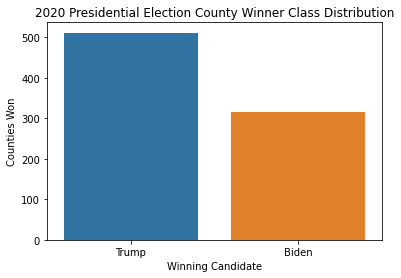

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='Winning Candidate', data=df, ax=ax)
ax.set_title('2020 Presidential Election County Winner Class Distribution')
ax.set_ylabel('Counties Won')
ax.set_xticklabels(['Trump', 'Biden'])


Plot distribution of each variable in dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

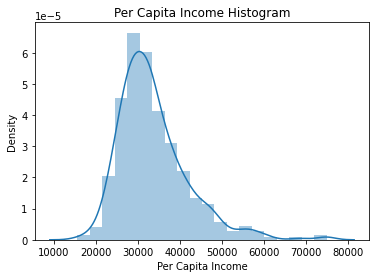

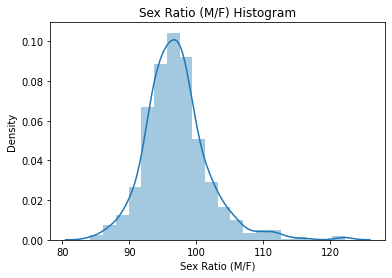

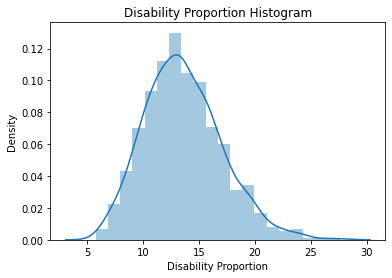

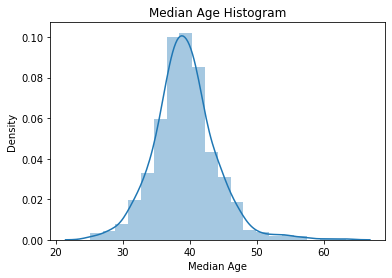

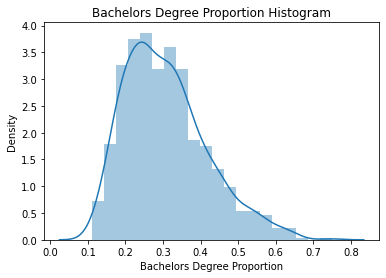

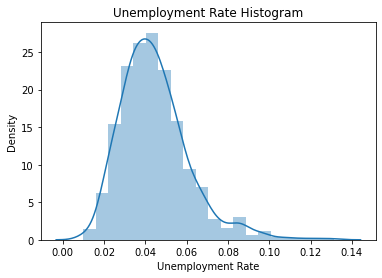

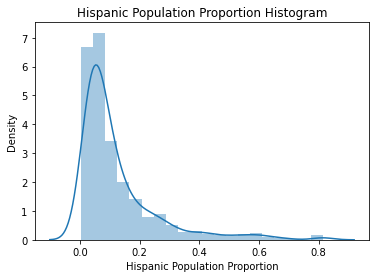

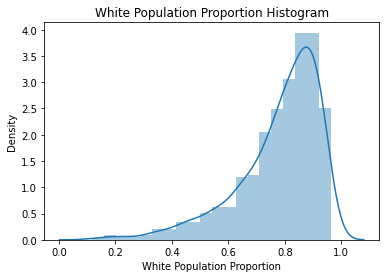

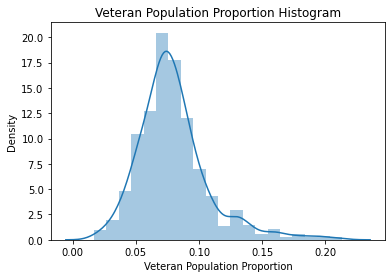

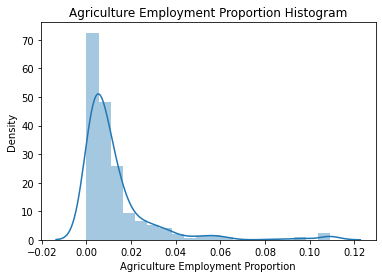

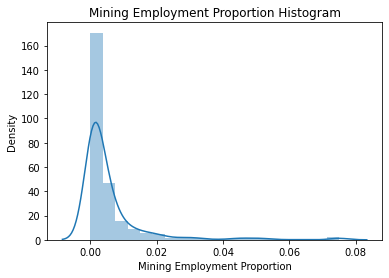

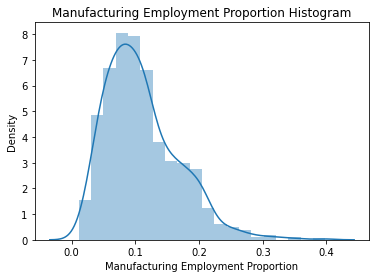

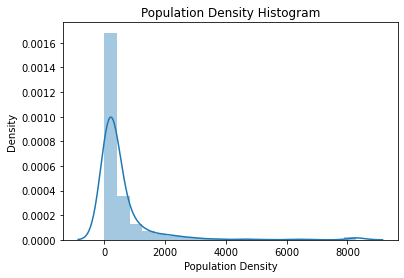

In [ ]:
for col in df.columns.drop('Winning Candidate'):
    fig, ax = plt.subplots()
    sns.distplot(df[col], bins=20, ax=ax)
    ax.set_title(f'{col} Histogram')

Plot relationship between each independent variable and the dependent variable

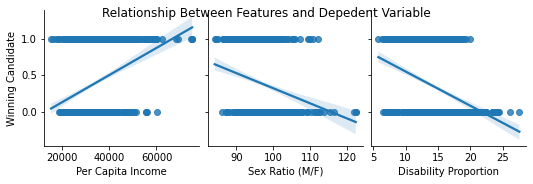

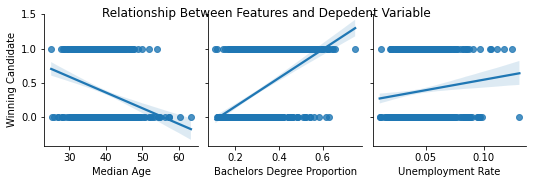

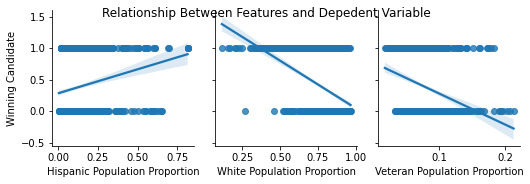

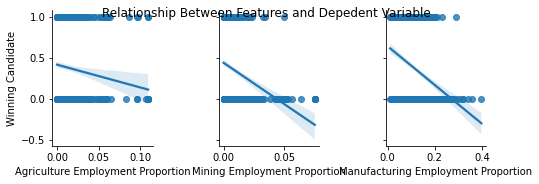

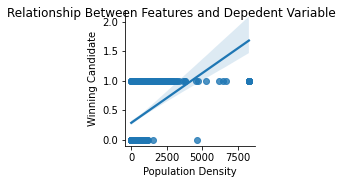

In [ ]:
y_var = 'Winning Candidate'
x_vars = list(df.columns)
x_vars.remove(y_var)

x_vars_lists = []
for num in range(0, len(x_vars), 3):
    x_vars_lists.append(x_vars[num: num+3])
x_vars_lists

for x_vars_list in x_vars_lists:
    pairplot = sns.pairplot(df, x_vars=x_vars_list, y_vars=y_var, kind='reg')
    pairplot.fig.suptitle('Relationship Between Features and Depedent Variable')

Confirm need to drop correlated features with vif

In [ ]:
vif_df = add_constant(df.drop(columns='Winning Candidate'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.round(decimals=1).reset_index(drop=True)

,Column,VIF
0,const,823.3
1,Bachelors Degree Proportion,5.8
2,Per Capita Income,5.4
3,Disability Proportion,2.7
4,Median Age,2.4
5,White Population Proportion,2.0
6,Population Density,1.7
7,Manufacturing Employment Proportion,1.7
8,Unemployment Rate,1.6
9,Hispanic Population Proportion,1.6


Calculate correlations between features

In [ ]:
df.corr().round(decimals=2)

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Winning Candidate
Per Capita Income,1.00,-0.05,-0.57,0.18,0.82,-0.38,-0.06,-0.02,-0.20,-0.23,-0.22,-0.24,0.38,0.32
Sex Ratio (M/F),-0.05,1.00,-0.03,-0.12,-0.12,-0.10,0.16,0.32,0.15,0.28,0.10,0.04,-0.20,-0.20
Disability Proportion,-0.57,-0.03,1.00,0.35,-0.64,0.40,-0.17,0.17,0.39,0.11,0.14,0.14,-0.27,-0.33
Median Age,0.18,-0.12,0.35,1.00,-0.13,-0.05,-0.29,0.35,0.25,-0.07,-0.10,0.08,-0.16,-0.22
Bachelors Degree Proportion,0.82,-0.12,-0.64,-0.13,1.00,-0.34,-0.09,-0.10,-0.28,-0.27,-0.27,-0.32,0.38,0.47
Unemployment Rate,-0.38,-0.10,0.40,-0.05,-0.34,1.00,0.17,-0.31,0.04,0.26,0.01,-0.04,0.02,0.10
Hispanic Population Proportion,-0.06,0.16,-0.17,-0.29,-0.09,0.17,1.00,-0.19,-0.21,0.34,0.16,-0.28,0.15,0.21
White Population Proportion,-0.02,0.32,0.17,0.35,-0.10,-0.31,-0.19,1.00,0.11,0.08,0.06,0.28,-0.44,-0.46
Veteran Population Proportion,-0.20,0.15,0.39,0.25,-0.28,0.04,-0.21,0.11,1.00,0.02,-0.02,-0.08,-0.31,-0.29
Agriculture Employment Proportion,-0.23,0.28,0.11,-0.07,-0.27,0.26,0.34,0.08,0.02,1.00,-0.01,-0.02,-0.23,-0.10


Drop Per Capita Income feature due to high correlation and recalculate vif

In [ ]:
df.drop(columns='Per Capita Income', inplace=True)
vif_df = add_constant(df.drop(columns='Winning Candidate'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.round(decimals=1).reset_index(drop=True)

,Column,VIF
0,const,783.8
1,Bachelors Degree Proportion,2.7
2,Disability Proportion,2.5
3,White Population Proportion,1.9
4,Manufacturing Employment Proportion,1.6
5,Population Density,1.6
6,Unemployment Rate,1.6
7,Hispanic Population Proportion,1.6
8,Veteran Population Proportion,1.5
9,Median Age,1.5


# Model Data

Create x and y variables

In [ ]:
y = df['Winning Candidate']
x = df.drop(columns='Winning Candidate')

Perform Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=31, test_size=.2)

Apply standard scaler to x and y variables

In [ ]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns = x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns = x.columns)
x_train.head()

,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density
0,0.679763,-0.116952,0.564303,0.234494,0.028943,-0.080975,0.184126,1.064640,-0.464765,-0.440574,0.308242,-0.207823
1,-1.614680,0.344906,-0.191990,0.355167,0.190036,-0.600689,-1.782677,-0.151856,-0.639347,-0.357010,-0.076998,0.016613
2,-0.772683,0.402639,-0.107957,0.266435,0.869728,0.398641,-1.008031,-0.834883,-0.603506,-0.516601,-0.672170,1.534922
3,0.006165,-0.694274,-0.191990,-1.044885,-0.863496,-0.322211,-0.593011,0.419075,0.529764,-0.043462,-0.730595,-0.432529
4,-0.246434,-0.954069,0.669343,1.011747,-0.912089,0.163543,0.336588,0.117361,-0.599999,-0.519858,-0.948348,-0.280635


Build and validate dummy classifier model

In [ ]:
dc = DummyClassifier(strategy='stratified')
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier
Train f1 Score:  0.3612903225806452
Train Accuracy:  0.55
Test f1 Score:  0.4375
Test Accuracy:  0.5662650602409639


Gridsearch elasticnet Logistic Regression model

In [ ]:
lr_gs_dic = {'C': [x/1000 for x in range(90, 111)], 'l1_ratio': [x/100 for x in range(0, 11)]}
lr_gs_model = LogisticRegression(penalty='elasticnet', solver='saga', random_state=7)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dic, scoring='f1', cv=5, verbose=1)
lr_gs.fit(x_train, y_train)
print('Logistic Regression Gridsearch')
print('Best Params', lr_gs.best_params_)
print('Best Score', lr_gs.best_score_)

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
Logistic Regression Gridsearch
Best Params {'C': 0.097, 'l1_ratio': 0.0}
Best Score 0.7775299203417789


Gridsearch l2 Logistic Regression model

In [ ]:
lr_gs_dic = {'C': [x/10000 for x in range(500, 601)], 'solver': ['newton-cg','liblinear','sag', 'saga', 'lbfgs']}
lr_gs_model = LogisticRegression(random_state=7)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dic, scoring='f1', cv=5, verbose=1)
lr_gs.fit(x_train, y_train)
print('Logistic Regression Gridsearch')
print('Best Params', lr_gs.best_params_)
print('Best Score', lr_gs.best_score_)

Fitting 5 folds for each of 505 candidates, totalling 2525 fits
Logistic Regression Gridsearch
Best Params {'C': 0.0542, 'solver': 'liblinear'}
Best Score 0.7839757935895457


Build and validate top performing logistic regression model

In [ ]:
lr = LogisticRegression(C=.0542, solver='liblinear', random_state=7)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression
Train f1 Score:  0.7833333333333334
Train Accuracy:  0.8424242424242424
Test f1 Score:  0.8034188034188035
Test Accuracy:  0.8614457831325302


Build a Confusion Matrix for the top performing Logistic Regression model

[Text(0, 0.5, 'Trump'), Text(0, 1.5, 'Biden')]

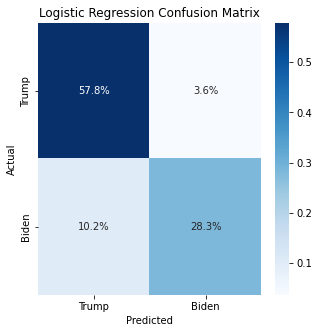

In [ ]:
lr_cm = confusion_matrix(y_test, y_test_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
lr_matrix = sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
lr_matrix.set_title('Logistic Regression Confusion Matrix')
lr_matrix.set_xlabel('Predicted')
lr_matrix.set_xticklabels(['Trump','Biden'])
lr_matrix.set_ylabel('Actual')
lr_matrix.set_yticklabels(['Trump','Biden'])

Gridsearch Adaboost model

In [ ]:
ab_gs_dic = {'learning_rate': [x/1000 for x in range(850, 951)], 'algorithm': ['SAMME', 'SAMME.R']}
ab_gs_model = AdaBoostClassifier(random_state=32)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dic, scoring='f1', cv=5, verbose=1)
ab_gs.fit(x_train, y_train)
print('Logistic Regression Gridsearch')
print('Best Params', ab_gs.best_params_)
print('Best Score', ab_gs.best_score_)

Fitting 5 folds for each of 202 candidates, totalling 1010 fits
Logistic Regression Gridsearch
Best Params {'algorithm': 'SAMME.R', 'learning_rate': 0.917}
Best Score 0.7854701927386822


Build and validate top performing Adaboost model

In [ ]:
ab = AdaBoostClassifier(learning_rate=.917, algorithm='SAMME.R', random_state=32)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred_ab))

Adaboost
Train f1 Score:  0.8676171079429736
Train Accuracy:  0.9015151515151515
Test f1 Score:  0.8130081300813008
Test Accuracy:  0.8614457831325302


Build a confusion matrix for the top performing Adaboost model

[Text(0, 0.5, 'Trump'), Text(0, 1.5, 'Biden')]

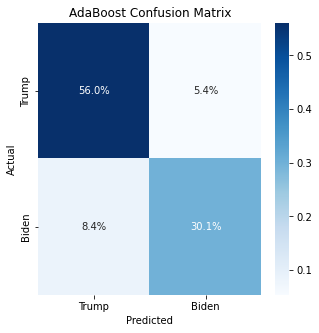

In [ ]:
ab_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
ab_matrix = sns.heatmap(ab_cm/np.sum(ab_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
ab_matrix.set_title('AdaBoost Confusion Matrix')
ab_matrix.set_xlabel('Predicted')
ab_matrix.set_xticklabels(['Trump','Biden'])
ab_matrix.set_ylabel('Actual')
ab_matrix.set_yticklabels(['Trump','Biden'])

Gridsearch Random Forest Model

In [ ]:
rf_gs_dic = {'max_features': [x/1000 for x in range(745, 756)],
             'max_samples': [x/1000 for x in range(825, 836)],
             'min_samples_split': [5, 6, 7, 8, 9],
             'criterion': ['gini', 'entropy']}
rf_gs_model = RandomForestClassifier(random_state=74)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dic, scoring='f1', cv=5, verbose=1)
rf_gs.fit(x_train, y_train)
print('Random Forest Gridsearch')
print('Best Params', rf_gs.best_params_)
print('Best Score', rf_gs.best_score_)

Fitting 5 folds for each of 1210 candidates, totalling 6050 fits
Random Forest Gridsearch
Best Params {'criterion': 'gini', 'max_features': 0.75, 'max_samples': 0.829, 'min_samples_split': 7}
Best Score 0.7873232148694719


Build and validate top performing Random Forest model

In [ ]:
rf = RandomForestClassifier(random_state=74, criterion='gini', max_features=0.75, max_samples=0.829, min_samples_split=7)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred_rf))

Random Forest
Train f1 Score:  0.98
Train Accuracy:  0.9848484848484849
Test f1 Score:  0.7903225806451613
Test Accuracy:  0.8433734939759037


Gridsearch xgboost model

In [ ]:
xgb_gs_dic = {'learning_rate': [.198, .199, .20, .21, .22],
              'reg_lambda': [2.5, 2.51, 2.52, 2.53, 2.54], 
              'gamma': [1.43, 1.44, 1.45, 1.46, 1.47],
             'subsample': [.588, .589, .59, .591, .592], 
              'colsample_bylevel': [.333, .334, .335, .336, .337]}
xgb_gs_model = XGBClassifier(random_state=53)
xgb_gs = GridSearchCV(xgb_gs_model, xgb_gs_dic, scoring='f1', cv=5, verbose=1, n_jobs=1)
xgb_gs.fit(x_train, y_train)
print('XGBoost Gridsearch')
print('Best Params', xgb_gs.best_params_)
print('Best Score', xgb_gs.best_score_)

Fitting 5 folds for each of 3125 candidates, totalling 15625 fits
XGBoost Gridsearch
Best Params {'colsample_bylevel': 0.334, 'gamma': 1.46, 'learning_rate': 0.199, 'reg_lambda': 2.51, 'subsample': 0.59}
Best Score 0.8007820347252116


Build and evaluate top performing xgboost model

In [ ]:
xgb = XGBClassifier(colsample_bylevel=0.334, gamma=1.46, learning_rate=0.199, reg_lambda=2.51, subsample=0.59,
                   random_state=53)
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('XGBoost')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_xgb))
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred_xgb))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_xgb))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred_xgb))

XGBoost
Train f1 Score:  0.9452332657200813
Train Accuracy:  0.9590909090909091
Test f1 Score:  0.784
Test Accuracy:  0.8373493975903614


# Analyze Results

Create df with coefficients from logistic regression model

In [ ]:
lr_coefficients_df = pd.DataFrame(lr.coef_, index=['Coefficient']).T
lr_coefficients_df['Feature'] = x_train.columns
lr_coefficients_df.sort_values(by='Coefficient', inplace=True)
lr_coefficients_df.reset_index(drop=True, inplace=True)
lr_coefficients_df

,Coefficient,Feature
0,-0.659723,White Population Proportion
1,-0.488872,Mining Employment Proportion
2,-0.281560,Veteran Population Proportion
3,-0.222097,Manufacturing Employment Proportion
4,-0.136779,Sex Ratio (M/F)
5,-0.135098,Median Age
6,-0.132143,Agriculture Employment Proportion
7,-0.075255,Disability Proportion
8,0.328041,Unemployment Rate
9,0.361707,Hispanic Population Proportion


Plot Biden Vote Proportion logistic regression model coefficients

Text(0.5, 1.0, '2020 Joe Biden Winning Counties Logistic Regression Coefficients')

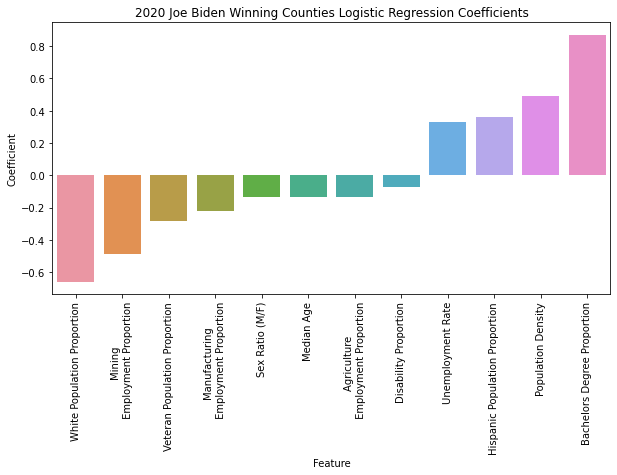

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Feature', y='Coefficient', data=lr_coefficients_df, ax=ax)

x_tick_labels = ['White Population Proportion', 'Mining \n Employment Proportion',
       'Veteran Population Proportion',
       'Manufacturing \n Employment Proportion', 'Sex Ratio (M/F)',
       'Median Age', 'Agriculture \n Employment Proportion',
       'Disability Proportion', 'Unemployment Rate',
       'Hispanic Population Proportion', 'Population Density',
       'Bachelors Degree Proportion']
ax.set_xticklabels(x_tick_labels, rotation=90)
ax.set_title('2020 Joe Biden Winning Counties Logistic Regression Coefficients')

Create df with feature importances from Adaboost model

In [ ]:
ab_importances_df = pd.DataFrame(ab.feature_importances_, columns=['Importance'])
ab_importances_df['Feature'] = x_train.columns
ab_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
ab_importances_df.reset_index(inplace=True, drop=True)
ab_importances_df

,Importance,Feature
0,0.16,Bachelors Degree Proportion
1,0.14,Mining Employment Proportion
2,0.12,Hispanic Population Proportion
3,0.10,White Population Proportion
4,0.10,Veteran Population Proportion
5,0.08,Population Density
6,0.06,Sex Ratio (M/F)
7,0.06,Disability Proportion
8,0.06,Unemployment Rate
9,0.06,Agriculture Employment Proportion


Plot Adaboost feature importances

Text(0.5, 1.0, '2020 Election Classification AdaBoost Feature Importances')

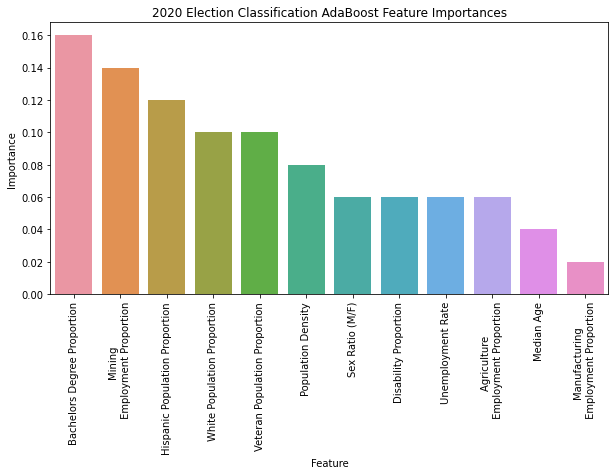

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Feature', y='Importance', data=ab_importances_df, ax=ax)

ab_importances_features = ['Bachelors Degree Proportion', 'Mining \n Employment Proportion',
       'Hispanic Population Proportion', 'White Population Proportion',
       'Veteran Population Proportion', 'Population Density',
       'Sex Ratio (M/F)', 'Disability Proportion', 'Unemployment Rate',
       'Agriculture \n Employment Proportion', 'Median Age',
       'Manufacturing \n Employment Proportion']
ax.set_xticklabels(ab_importances_features, rotation=90)
ax.set_title('2020 Election Classification AdaBoost Feature Importances')